<a href="https://colab.research.google.com/github/noteisenheim/investigating_gans/blob/main/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate hand-written digits with TF tutorial

The intro to GAN

Generating the hand-written digits using the MNIST dataset

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [3]:
# use GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers

from IPython import display

## Loading the data

The data is taken from the MNIST dataset available in tensorflow

The dataset is downloaded, then preprocessed: reshaped and normalized, and finally is split into batches

In [5]:
# download train data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
# reshape and normalize images
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [8]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator model

The generator uses Transpose Convolution layers in order to make an upscaling from the noise given as input

The activation used is Leaky ReLU, except from the last layer, where tanh is used

In [9]:
def make_generator():
    # create the generator model
    with tf.device('/device:GPU:0'):
        model = tf.keras.Sequential()
        model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((7, 7, 256)))

        model.add(layers.Conv2DTranspose(128, (5, 5), (1, 1), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', use_bias=False))  
        model.add(layers.BatchNormalization())  
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(1, (5, 5), (2, 2), activation='tanh', padding='same', use_bias=False))  

        return model

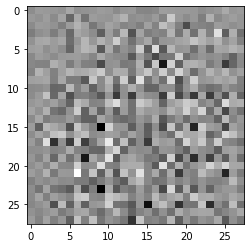

In [10]:
# create the generator
generator = make_generator()

# generate a noisy image on a non-trained generator
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)

plt.imshow(gen_img[0, :, :, 0], cmap='gray')

## Discriminator model

A simple CNN with 2 convolution layers, output is the probability of the image to be a real drawing

In [11]:
def make_discriminator():
    # create a discriminator model
    with tf.device('/device:GPU:0'):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), (2, 2), padding='same', input_shape=[28, 28, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(128, (5, 5), (2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

In [12]:
# create a discriminator model
discriminator = make_discriminator()

# make a decision on a sample image
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[-0.00023909]], shape=(1, 1), dtype=float32)


## Training

The loss used is cross-entropy

For optimization the Adam optimizer is used

In [13]:
# define loss
with tf.device('/device:GPU:0'):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    # cross-entropy loss for discriminator
    # compare real ones with ones array
    # fake ones with zeros array
    with tf.device('/device:GPU:0'):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss

        return total_loss

In [15]:
def generator_loss(fake_output):
    # cross-entropy loss for generator
    # compare with ones
    with tf.device('/device:GPU:0'):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# define optimizers
with tf.device('/device:GPU:0'):
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# how to create a checkponts
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dim])

In [19]:
# @tf.function for the function to be compiled

@tf.function
def train_step(images):
    # a single training step
    with tf.device('/device:GPU:0'):
        # a noisy input to the generator
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # run the generator
            generated_images = generator(noise, training=True)

            # run the discriminator
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            # calculate losses
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

In [20]:
def generate_and_save_images(model, epoch, test_input):
    # save the output of each step
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig(f'epoch_{epoch}_img.png')
    plt.show()

In [21]:
import time

def train(dataset, epochs):
    with tf.device('/device:GPU:0'):
        for epoch in range(epochs):
            start = time.time()

            for image_batch in dataset:
                train_step(image_batch)

            # generate image
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch+1, seed)

            # save every 15 epochs
            if (epoch + 1) % 15 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)

            print(f'time for epoch {epoch} is {time.time() - start}')

        # image after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

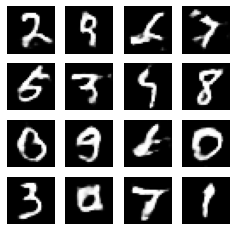

In [22]:
train(train_dataset, EPOCHS)

## Display the output

Here are the examples of a single generated image and a gif presenting how the generated images evolved

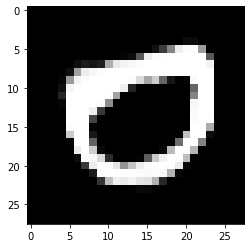

In [23]:
# generate an image on a trained generator
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)

plt.imshow(gen_img[0, :, :, 0], cmap='gray')

In [24]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [25]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ehi4e0ol
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ehi4e0ol
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.070f8a1484cf809ec5bbe7aafa4fb5970a8c2ac54_-cp36-none-any.whl size=144911 sha256=cc5b5bc8e1e9dc3871e7b72e81200c54a66568cac8bcddda09dd548fc38b5d91
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvnfbq5z/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs



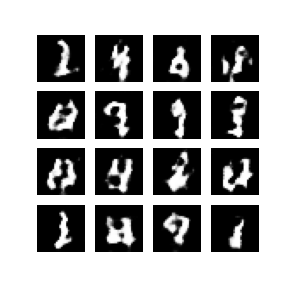

In [26]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)